Mount Drive dan Setup Folder

In [1]:
from google.colab import drive
import os

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/ANTMcast')
print("Current Directory:", os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current Directory: /content/drive/MyDrive/ANTMcast


Import Library

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib

Load Dataset .npz (Windowed Time Series)

In [3]:
data = np.load('data/processed/antm_timeseries_window.npz')
X, y = data['X'], data['y']

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1529, 20, 6)
y shape: (1529,)


Flatten Input untuk BPNN

In [4]:
# BPNN menerima input vektor, jadi kita ubah (samples, timesteps, features) → (samples, timesteps * features)
X_flat = X.reshape(X.shape[0], -1)
print("Flattened X shape:", X_flat.shape)

Flattened X shape: (1529, 120)


Split Train/Test

In [5]:
split = int(0.8 * len(X_flat))
X_train, X_test = X_flat[:split], X_flat[split:]
y_train, y_test = y[:split], y[split:]

print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Test : {X_test.shape}, {y_test.shape}")

Train: (1223, 120), (1223,)
Test : (306, 120), (306,)


Bangun Arsitektur Model BPNN

In [6]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))  # output harga

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        15,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,809 (93.00 KB)

 Trainable params: 23,809 (93.00 KB)

 Non-trainable params: 0 (0.00 B)

Kompilasi Model

In [7]:
model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

Latih Model

In [8]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0508 - root_mean_squared_error: 0.2214 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0642
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0098 - root_mean_squared_error: 0.0989 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0616
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0054 - root_mean_squared_error: 0.0737 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0574
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0040 - root_mean_squared_error: 0.0632 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0576
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - root_mean_squared_error: 0.0542 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0465
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0027 - root_mean_squared_error: 0.0523 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0531
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss:

Simpan Model BPNN

In [9]:
model.save('models/bpnn_model.h5')
print("✅ Model BPNN disimpan di: models/bpnn_model.h5")

✅ Model BPNN disimpan di: models/bpnn_model.h5


Visualisasi Loss dan RMSE

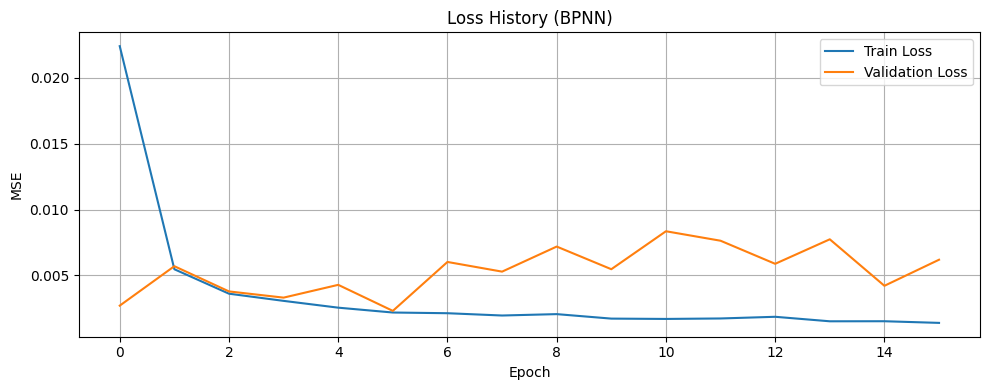

In [23]:
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss History (BPNN)')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Evaluasi MAE dan RMSE

In [10]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
MAE  : 0.0305
RMSE : 0.0423


Visualisasi Hasil Prediksi vs Aktual

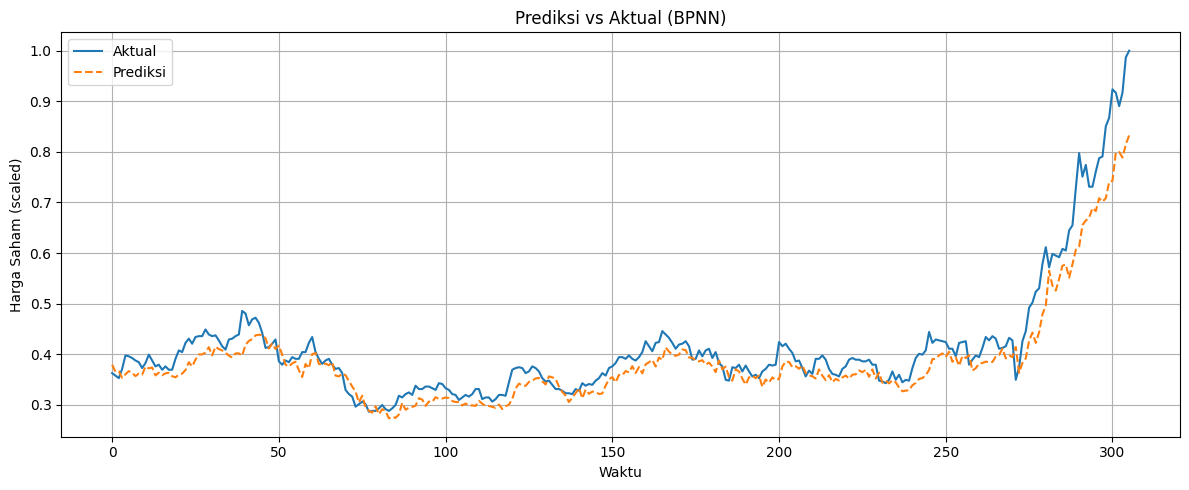

In [11]:
plt.figure(figsize=(12, 5))
plt.plot(y_test, label='Aktual')
plt.plot(y_pred, label='Prediksi', linestyle='--')
plt.title('Prediksi vs Aktual (BPNN)')
plt.xlabel('Waktu')
plt.ylabel('Harga Saham (scaled)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Simpan Hasil Evaluasi ke File

In [12]:
eval_df = pd.DataFrame({
    'MAE': [mae],
    'RMSE': [rmse]
})
eval_df.to_csv('results/reports/evaluation_bpnn.csv', index=False)
print("📊 Hasil evaluasi disimpan di: results/reports/evaluation_bpnn.csv")

📊 Hasil evaluasi disimpan di: results/reports/evaluation_bpnn.csv
